In [22]:
import numpy as np
import numpy.random as ra
import numpy.linalg as la
from tqdm import tqdm
import matplotlib.pyplot as plt
# plt.style.use("ggplot")

### Utils

In [23]:
def calc_sqrt_b_ridge(k,sigma_2,lamda,delta,S_hat,logdetG):
    '''Returns confidence interval width for ridge regression'''
    return sigma_2 * np.sqrt( logdetG - k * np.log(lamda) + np.log(1/(delta**2)) ) + np.sqrt(lamda) * S_hat 

def calc_sqrt_b_2sls(k,sigma_2,lamda,delta,S_hat,logdetG):
    '''Returns confidence interval width for 2SLS regression'''
    return sigma_2 * np.sqrt( logdetG - k * np.log(lamda) + np.log(1/(delta**2)) )

def runit(nb_exp, Z, X, theta, S_hat, sigma_1, sigma_2,lamda,delta, seed, eps, algorithm='ridge'):
    '''function used to run an instance of linear bandits using OFUL with ridge or 2SLS regression
    :param nb_exp: integer, number of runs used to average noise
    :param X: tuple, dimensions (T,n_a,d) where T: #observations, n_a: #actions, d: #covariates
    :param beta: vector of R^d, reward function parameter
    :param S_hat: float, such that ||beta||_2 < S_hat
    :param sigma_2: float, variance of the noise
    :param lamda: float, regularization
    :param delta: float, power of the confidence intervals
    :param seed: float, fix seed for reproducibility
    :param algorithm: string, ridge or 2SLS
    '''
    np.random.seed(seed)
    T, nb_actions, d = X.shape
    regret = np.zeros((nb_exp,T))
    pred_norms = np.zeros((nb_exp,T))
    x_inv_norms = np.zeros((nb_exp,T))
    beta_hat_ridge_rec = np.zeros((nb_exp,T,d))
    beta_hat_2sls_rec = np.zeros((nb_exp,T,d))
        
    for i in tqdm(range(nb_exp)):


        





        Gxx, invGxx = lamda*np.eye(d), np.eye(d)/lamda
        ZXt = 1e-4*np.eye(d)
        Zyt = np.zeros(d)
        Gzz, invGzz = lamda*np.eye(d), np.eye(d)/lamda # is the regularizer correct here???
        invThetaHat = np.eye(d)/lamda     # 
        logdetG = d*np.log(lamda)
        Xyt = np.zeros(d) 
        sqrt_b_ridge = calc_sqrt_b_ridge(d, sigma_2, lamda, delta, S_hat, logdetG)
        sqrt_b_2sls = calc_sqrt_b_2sls(d, sigma_2, lamda, delta, S_hat, logdetG)
        beta_hat_ridge = np.zeros(d)
        beta_hat_2sls = np.zeros(d)

        for t in range(T):
            z = Z[t]
            x = X[t]
   
            if algorithm == 'ridge':
                X_invGt_norm_sq = np.sum(np.dot(x, invGxx) * x, 1)
                x_inv_norms[i,t] = max(X_invGt_norm_sq)
                preds = np.dot(x, beta_hat_ridge)
                pred_norms[i,t] = np.linalg.norm(preds)
                obj = preds + sqrt_b_ridge * np.sqrt(X_invGt_norm_sq) 

            if algorithm == '2sls':
                X_invThetaHat_invGt_invThetaHatT_norm_sq = np.sum((x @ invThetaHat @ invGzz @ invThetaHat.T) * x,1)
                # X_invThetaHat_invGt_invThetaHatT_norm_sq = np.sum((x @ invGzz) * x,1)
                x_inv_norms[i,t] = max(X_invThetaHat_invGt_invThetaHatT_norm_sq)
                preds = np.dot(x, beta_hat_2sls)
                pred_norms[i,t] = np.linalg.norm(preds)
                obj = preds + sqrt_b_2sls * np.sqrt(X_invThetaHat_invGt_invThetaHatT_norm_sq) 

            # Pull the arm with the highest estimated value
            pulled_idx = np.argmax(obj)  
            

            # second stage
            ee = d//3
            eta_tilde = np.random.normal(0,1) 
            # eta = (eta_tilde + np.sum(eps[t,:,:ee]))/(1+ee*sigma_1)*sigma_2
            eta = (eta_tilde + np.sum(eps[t,:,:ee]))
            # x /= np.max(np.linalg.norm(x)) # ???? do I need it here ????
            xt = x[pulled_idx, :]
            zt = z[pulled_idx, :]
            y = np.dot(x, beta_star) + eta
            yt = y[pulled_idx]
            # compute regret 
            regret[i,t] = np.max(np.dot(x, beta_star))-np.dot(xt, beta_star) # maybe I should change this definition of regret
            # regret[i,t] = np.max(y) - yt # maybe I should change this definition of regret


            # build estimators
            if algorithm == 'ridge':
                Xyt += xt*yt
                Gxx += np.outer(xt, xt)
                tempval1 = np.dot(invGxx, xt)    # d by 1, O(d^2)
                tempval2 = np.dot(tempval1, xt)      # scalar, O(d)
                logdetG += np.log(1 + tempval2)
                if (t % 20 == 0):
                    invGxx = np.linalg.inv(Gxx)
                else:
                    invGxx -= np.outer(tempval1, tempval1) / (1 + tempval2) 
                beta_hat_ridge = np.dot(invGxx, Xyt)
                sqrt_b_ridge = calc_sqrt_b_ridge(d, sigma_2, lamda, delta, S_hat, logdetG)
                beta_hat_ridge_rec[i,t, :] = beta_hat_ridge
                # print(beta_hat_ridge)
            
            if algorithm == '2sls': # check all inverse here
                Zyt += zt*yt
                ZXt += np.outer(zt, xt)
                Gzz += np.outer(zt, zt)  # ????? regularizer here is it correct
                tempval1 = np.dot(invGzz, zt)    # d by 1, O(d^2)
                tempval2 = np.dot(tempval1, zt)      # scalar, O(d)
                logdetG += np.log(1 + tempval2)
                if (t % 20 == 0):
                    invGzz = np.linalg.inv(Gzz)
                else:
                    invGzz -= np.outer(tempval1, tempval1) / (1 + tempval2) 
                beta_hat_2sls = np.linalg.inv(ZXt + 1e-4*np.eye(d)) @ Zyt
                ThetaHat = invGzz @ ZXt
                invThetaHat =  np.linalg.inv(ThetaHat)
                sqrt_b_2sls = calc_sqrt_b_2sls(d, sigma_2, lamda, delta, S_hat, logdetG)
                beta_hat_2sls_rec[i,t, :] = beta_hat_2sls    
                # print(beta_hat_2sls)

            
    if algorithm == 'ridge':
        return regret, pred_norms, x_inv_norms, beta_hat_ridge_rec
    elif algorithm == '2sls':
        return regret, pred_norms, x_inv_norms, beta_hat_2sls_rec
    else:
        print("error")


### Experiments

In [24]:
S, sigma_1, sigma_2 = 1, 1, 1
T, n_a, d = int(1e3), 100, 20
theta_star = np.random.randn(d,d);  #theta_star *= 1/np.linalg.norm(theta_star) #maybe this can be changed
beta_star = np.random.multivariate_normal([10],[[1]],d).reshape(-1,) #; beta_star *= S/np.linalg.norm(beta_star)
# print("beta = ", beta_star, "\ntheta = ", theta_star)

In [33]:
# first stage
# X_max = 100
Z = np.random.randn(T, n_a, d) #; Z /= np.max(np.linalg.norm(Z,axis=2))/X_max
eps = sigma_1*np.random.randn(T, n_a, d)
# eps = np.zeros((T,d))
X = np.dot(Z, theta_star) + eps

# second stage
ee = d//5
eta_tilde = np.random.randn(T, n_a) 
# eta = (eta_tilde + np.sum(eps[t,:,:ee]))/(1+ee*sigma_1)*sigma_2
eta = eta_tilde + eps[:,:,:ee].sum(axis=2)
# x /= np.max(np.linalg.norm(x)) # ???? do I need it here ????
xt = x[pulled_idx, :]
zt = z[pulled_idx, :]
y = np.dot(x, beta_star) + eta
yt = y[pulled_idx]

In [26]:
lamda = 0.1 #1/T
delta = 0.001
seed = 1996
S_hat = S
nb_exp = 100
algorithms = ['ridge','2sls']
labels = ['OFUL$^{r}$','OFUL$^{f}$']
# colors = ['blue','darkviolet','darkorange']#,'darkred']
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
# s_colors = ['cyan','violet','orange']#,'red']
regrets = np.zeros((nb_exp,len(algorithms),T))
pred_norms = np.zeros((nb_exp,len(algorithms),T))
x_inv_norms = np.zeros((nb_exp,len(algorithms),T))
# beta_hat_ridge = np.zeros((nb_exp,T,d))
beta_hat = np.zeros((nb_exp, len(algorithms), T,d))

for i,a in enumerate(algorithms):
    regrets[:,i,:], pred_norms[:,i,:], x_inv_norms[:,i,:], beta_hat[:, i, :,:] = runit(nb_exp, Z, X, beta_star, S_hat, sigma_1, sigma_2, lamda, delta, seed, eps, a)

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


In [30]:
# print(np.linalg.norm(beta_hat[:, 0, -1, :]-beta_star, axis=1).mean())
# print(np.linalg.norm(beta_hat[:, 1, -1, :]-beta_star, axis=1).mean())

print(np.linalg.norm((beta_star-beta_star).mean(axis=0)))
print(np.linalg.norm((beta_hat[:, 0, -1, :]-beta_star).mean(axis=0)))
print(np.linalg.norm((beta_hat[:, 1, -1, :]-beta_star).mean(axis=0)))
# print(np.linalg.norm(beta_hat_2sls[0, -1,:]-beta_star))

mean_beta_ridge = beta_hat[:, 0, -1, :].mean(axis=0)
mean_beta_2sls = beta_hat[:, 1, -1, :].mean(axis=0)
print(beta_star) 
print(mean_beta_ridge) 
print(mean_beta_2sls)

# std_beta_ridge = beta_hat_ridge[0, :, :].std(axis=0)
# mean_beta_2SLS = beta_hat_2sls[1, :, :].mean(axis=0)
# std_beta_2SLS = beta_hat_2sls[1, :, :].std(axis=0)
# mean_beta_star = beta_star
# std_beta_star = beta_star


# # Here I make comparisons with mean values for different iterations and final estimates of beta

# mean_beta_ridge = store_betas[0, :, :].mean(axis=0)
# std_beta_ridge = store_betas[0, :, :].std(axis=0)
# mean_beta_2SLS = store_betas[1, :, :].mean(axis=0)
# std_beta_2SLS = store_betas[1, :, :].std(axis=0)
# mean_beta_star = store_betas[2, :, :].mean(axis=0)
# std_beta_star = store_betas[2, :, :].std(axis=0)

# print("||beta - mean_s|| = ", round(np.linalg.norm(beta_star-mean_beta_star),4), "\tbeta = ", beta_star, "\t\tstd=", std_beta_star)
# print("||beta - mean_r|| = ", round(np.linalg.norm(beta_star-mean_beta_ridge),4),  "\tbeta_r = ", betas[0], "\tstd=", std_beta_ridge)
# print("||beta - mean_IV|| = ", round(np.linalg.norm(beta_star-mean_beta_2SLS),4), "\tbeta_IV = ", betas[1], "\tstd=", std_beta_2SLS)
# print("L_Z is: ", round(L_Z,4))
# print("L_X is: ", round(L_X,4))
# print("L_y is: ",round(L_y,4))
# print("max |eta_t| is: ", max(abs(eta)))
# print(methods)
# print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))


0.0
2.834008939400128
6.274238959435114
[10.42427725  9.6183226  10.4289938   9.44469759  9.20004203 10.94304065
 10.99009364  9.74968379 10.16916147  9.52121444  8.93704074 10.49929368
 10.95202454  8.81844519  9.50837234  8.79337967 10.04153494 10.0724303
  9.25626347  9.3107922 ]
[ 9.73786943  9.99922578 11.43355937 10.45774651  9.79914718 12.06852277
 11.35931256 10.38172439 10.37811147  9.60741077  9.32525737  9.55369984
 10.49988603  8.43157846  9.684034    8.61033957 10.4766802  10.41027038
  8.89253404 10.43698789]
[ 8.65119176 11.02347262  9.30189893 10.83641824 10.00628431 11.92483492
 10.37812346 12.65671274 10.12648057  9.2771293   9.46148927  8.74518242
 10.13239287  9.64080034  9.20177584  8.51180212 10.1423347  11.39217671
  9.95235776 12.97550959]


### Regret

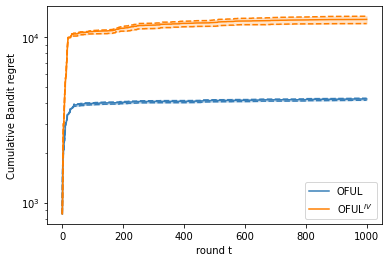

In [28]:
mean_regret = np.cumsum(regrets.mean(axis=0),axis=1)
fst_quantile_regret = np.cumsum(np.quantile(regrets,0.25,axis=0),axis=1)
thd_quantile_regret = np.cumsum(np.quantile(regrets,0.75,axis=0),axis=1)
std_regret = np.cumsum(regrets,axis=2).std(axis=0)
# _ = np.log(lamda+(X_max**2)*np.arange(1,T+1)/d)

labels = ['OFUL','OFUL$^{IV}$']


for i,a in enumerate(algorithms):
#     plt.plot(np.divide(mean_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),label=labels[i],color=colors[i])
    plt.plot(mean_regret[i],label=labels[i],color=colors[i])
#     plt.fill_between(np.arange(T),np.divide(fst_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),np.divide(thd_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),color=colors[i],alpha=0.2)
    plt.fill_between(np.arange(T),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
#     plt.fill_between(np.arange(T),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.1)
log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("round t")
plt.ylabel('Cumulative Bandit regret')
# plt.ylim([0,500])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
# plt.savefig(folder+"lamda_"+str(lamda)+'_sigma_'+str(sigma)+"_X_"+str(X_max)+"_S_"+str(S)+"_delta_"+str(delta)+".pdf",bbox_inches='tight')
plt.show()

In the following cells, we visualize how the parameter estimate's norm evolves over time, this is not discussed in the paper, but it allows us to see how much the ``bounded predictions'' assumption is violated 

### Prediction norms

In [ ]:
mean_norms = pred_norms.mean(axis=0)
plt.plot(mean_norms[0]-mean_norms[1])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
# plt.yscale("log")

### distance of new points to old

In [ ]:
# Here we visualize the sum of features' norms $x_t^T G_{t}^{-1} x_t$ for both algorithms
mean_x_inv_norms = x_inv_norms.mean(axis=0)
plt.plot(mean_x_inv_norms[0])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.yscale("log")